# 第三週：基本文字資料的處理(英文)
**Author:** 蔡睿澤<br>
**Date created:** 2023/02/17<br>
**Last modified:** 2023/02/28<br>

本週課程為「基本文字資料的處理」，目的為了解基本的文字處理概念。文字處理的步驟會因所要分析之語言不同而有所差異，在這個Jupyter Notebook當中將會展示「英文」的文字處理過程，並且搭配python程式碼進行講解。在後面的內容中，我們將會介紹所使用到的套件、Tidy Data以及文字處理的基本流程等三個部分。

## 大綱
1. 套件說明
2. Tidy Data
3. 文字處理基本流程

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。

- Pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。 (補充：[其他不同的NLP工具](https://www.upgrad.com/blog/python-nlp-libraries-and-applications/))
- re: 正規表達式套件。
- wordcloud: 文字雲繪圖工具。
- matplotlib: 繪圖工具。

In [1]:
# 載入套件
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re

from wordcloud import WordCloud # pip install wordcloud
import matplotlib.pyplot as plt

# 下載斷句需要的資源
# nltk.download('punkt')
# 下載POS tagger需要的資源
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('averaged_perceptron_tagger')

In [50]:
# 設定圖的字體大小
plt.rcParams['font.size'] = 14

## 2. Tidy Data
在進行資料分析的過程當中，資料清理是一個不可或缺的環節，資料清理的精細程度也會直接影響結果好壞。而在機器學習的領域當中，我們通常會將文字型資料(Textual Data)視為是一種非結構化資料(Unstructure Data)。這樣的非結構化資料是需要透過特定的清理方式將其轉為結構化資料之後，才能夠為後續分析使用。這樣的處理方式我們將其稱為Data Tidying。而處理過後的「乾淨」的資料，我們就把它叫做Tidy Data。其定義的原則如下：

1. 每個變數分別在個別的欄位。
2. 每筆觀察值形成一列。
3. 不同主題要用不同table來整理。

接著我們用一個範例來介紹Tidy Data。

下面圖片中的兩個表格是使用相同的資料，但不同的表達方式。其概念都是要用來描述不同的人(person)在不同的實驗(treatmenta, treatmentb)當中的結果(表格中的數字)。

<img src="./pic/untidy.png" alt="untidy_table" width="400"/>

而這樣的資料其實是不利於資料分析的進行的。我們用剛才所定義的原則來將資料轉換為Tidy Data(如下圖中的表格)，可以看到資料其實是包含了三個變數、六個觀察值。也就是說我們可以用一個Pandas的DataFrame來表達資料。

<img src="./pic/tidy_table.png" alt="tidy_table" width="400"/>

#### Tidy Data 小練習
我們將建立出一個Pandas DataFrame的物件來儲存資料，這裡用Python Dict來建立DataFrame。Dict裡的key值(下面的treatment、John Smith...)對應到一個欄位的名稱，而其值(value)則是其欄位裡的所有值。

In [51]:
treatmentData = pd.DataFrame({
    'treatment':['treatmenta','treatmentb'],
    'John Smith':[1,4],
    'Jane Doe':[2,5],
    'Mary Johnson':[3,6]
})
treatmentData

,treatment,John Smith,Jane Doe,Mary Johnson
0,treatmenta,1,2,3
1,treatmentb,4,5,6


將以上非Tidy 格式的dataframe使用pandas的function將其轉換成Tidy格式

In [52]:
treatmentData_melt = pd.melt(treatmentData, id_vars=['treatment'])
treatmentData_melt

,treatment,variable,value
0,treatmenta,John Smith,1
1,treatmentb,John Smith,4
2,treatmenta,Jane Doe,2
3,treatmentb,Jane Doe,5
4,treatmenta,Mary Johnson,3
5,treatmentb,Mary Johnson,6


在Python中的資料表可使用Pandas DataFrame儲存，Pandas套件也提供了許多的函數可以進行資料的轉換與操作

有關DataFrame的操作可參考Pandas官網的[教材](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html)

## 3. 文字處理基本流程
接下來的章節我們將介紹文字處理的基本流程。其中大概可以分為六個步驟

+ **資料蒐集：** <br>
如同上面所述，文字型資料被視為是一種非結構化的資料。其資料來源相當的廣泛，如：論壇、新聞網、社群媒體、專利、論文等...。其中，論壇、新聞網、社群媒體這類由使用者所產生出來的資料我們將其稱為User Generated Data(UGC)。通常來說，我們會使用網路爬蟲的技術來取得這樣的資料(網路爬蟲的技術不會在此範例中討論)。 <br><br>
+ **資料初步清理：** <br>
將文字內容轉為正規的語句，例如：去除特定標籤、符號、統一標點符號的使用等等 <br><br>
+ **斷句斷詞：** <br>
使用工具區隔文章中不同的句子、詞彙 <br><br>
+ **去除停用字：** <br>
停用字就是與分析無關的詞彙，甚至這些詞彙可能會影響分析的結果。因此我們必須在資料處理的過程中將其排除。例如：語助詞 <br><br>
+ **產生結構化資料：** <br>
根據需求產生不同結構化資料(Tidy Data)，以供後續分析使用。 <br><br>
+ **應用更多分析：** <br>
進行不同的分析，例如：情緒分析、詞頻分析

### 3.1 資料蒐集
在後續的範例中，我們將使用PRIDE & PREJUDICE這本書來說明文字分析的技術。

讀取PRIDE & PREJUDICE的檔案(來源：[古騰堡-傲慢與偏見](https://www.gutenberg.org/files/1342/1342-h/1342-h.htm))

In [2]:
book = open('raw_data/PRIDE & PREJUDICE.txt', mode='r', encoding="utf-8")
content = book.read()

將內文用DataFrame的格式儲存

In [3]:
content_dict = {'text': [content]}
content_df = pd.DataFrame(content_dict)
content_df

,text
0,﻿TPRIDE & PREJUDICE.\n\n\n\n\nCHAPTER I.\n\n\n...


### 3.2 斷句

使用NLTK套件的斷句函式來實作斷句，並將文件整理成我們要的Tidy Data格式。步驟解釋如下：

+ assign : 新增一個欄位「sentence」，值為content_df['text']進行nltk_word_tokenize的結果
+ explode : word_tokenize的結果為list，因此用explode將list裡的每個值變單獨一行
+ drop : 將欄位「text」刪除，axis=1為對縱軸操作(column)，axis=0為對橫軸操作(row)

*大家可以試著將explode()或drop()拿掉，看看結果有什麼變化*

In [4]:
content_df = content_df.assign(sentence = content_df['text'].apply(nltk.sent_tokenize)).explode('sentence').drop(['text'], axis=1)
content_df

,sentence
0,﻿TPRIDE & PREJUDICE.
0,CHAPTER I.
0,"It is a truth universally acknowledged, that a..."
0,However little known the feelings or views of ...
0,"""My dear Mr. Bennet,"" said his lady to him one..."
...,...
0,By Elizabeth's instructions she began to compr...
0,Lady Catherine was extremely indignant on the ...
0,"But at length, by Elizabeth's persuasion,\nhe ..."
0,"With the Gardiners, they were always on the mo..."


### 3.3 資料整理

使用re套件並用正規表達式比對出章節每個句子所屬的章節，並在DataFrame中新增一個章節(chapter)的欄位

In [5]:
def get_chapter_sentences(list):
    if re.search('CHAPTER', list) == None:
        return 0
    else:
        return 1

content_df['chapter'] = content_df['sentence'].apply(get_chapter_sentences).cumsum()
content_df

,sentence,chapter
0,﻿TPRIDE & PREJUDICE.,0
0,CHAPTER I.,1
0,"It is a truth universally acknowledged, that a...",1
0,However little known the feelings or views of ...,1
0,"""My dear Mr. Bennet,"" said his lady to him one...",1
...,...,...
0,By Elizabeth's instructions she began to compr...,61
0,Lady Catherine was extremely indignant on the ...,61
0,"But at length, by Elizabeth's persuasion,\nhe ...",61
0,"With the Gardiners, they were always on the mo...",61


### 3.4 移除無意義字、標點符號
清除CHAPTER的句子，並將長度小於1的句子刪除<br>
清除文本中的標點符號、數字以及換行符號

In [6]:
# 刪除CHAPTER的列
content_df = content_df[~content_df["sentence"].str.contains("CHAPTER")]

# 刪除長度小於1的句子
content_df = content_df[~content_df["sentence"].str.len() < 1]

# 刪除標點符號/數字/換行符號
content_df["sentence"] = content_df["sentence"].str.replace(r'[^a-zA-Z\s]','')  #只留下英文字母和空格(包含換行符號)
content_df["sentence"] = content_df["sentence"].str.replace(r'[\n]',' ')    #將換行符號替換成空格

content_df

/var/folders/wb/4p2wtwfn0hbfl5wk9721_6gm0000gn/T/ipykernel_58675/1070961234.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  content_df["sentence"] = content_df["sentence"].str.replace(r'[\n]',' ')    #將換行符號替換成空格


,sentence,chapter
0,﻿TPRIDE & PREJUDICE.,0
0,"It is a truth universally acknowledged, that a...",1
0,However little known the feelings or views of ...,1
0,"""My dear Mr. Bennet,"" said his lady to him one...",1
0,Mr. Bennet replied that he had not.,1
...,...,...
0,By Elizabeth's instructions she began to compr...,61
0,Lady Catherine was extremely indignant on the ...,61
0,"But at length, by Elizabeth's persuasion, he w...",61
0,"With the Gardiners, they were always on the mo...",61


### 3.5 斷詞
使用NLTK的斷詞函式進行斷詞，將DataFrame處理成一個row一個斷詞的結果

In [66]:
token_df = content_df.assign(token = content_df['sentence'].apply(nltk.word_tokenize)).explode('token')
token_df

,sentence,chapter,token
0,TPRIDE PREJUDICE,0,TPRIDE
0,TPRIDE PREJUDICE,0,PREJUDICE
0,It is a truth universally acknowledged that a ...,1,It
0,It is a truth universally acknowledged that a ...,1,is
0,It is a truth universally acknowledged that a ...,1,a
...,...,...,...
0,Darcy as well as Elizabeth really loved them a...,61,the
0,Darcy as well as Elizabeth really loved them a...,61,means
0,Darcy as well as Elizabeth really loved them a...,61,of
0,Darcy as well as Elizabeth really loved them a...,61,uniting


### 3.6 字詞正規化

#### 3.6.1 大小寫轉換

一種簡單的正規化方式為統一大小寫的字母，這樣在計算詞頻(或其他的匯總)時會將拼法一樣的字合併計算。

In [67]:
lowerWord_df = token_df.assign(word = token_df['token'].str.lower())
lowerWord_df

,sentence,chapter,token,word
0,TPRIDE PREJUDICE,0,TPRIDE,tpride
0,TPRIDE PREJUDICE,0,PREJUDICE,prejudice
0,It is a truth universally acknowledged that a ...,1,It,it
0,It is a truth universally acknowledged that a ...,1,is,is
0,It is a truth universally acknowledged that a ...,1,a,a
...,...,...,...,...
0,Darcy as well as Elizabeth really loved them a...,61,the,the
0,Darcy as well as Elizabeth really loved them a...,61,means,means
0,Darcy as well as Elizabeth really loved them a...,61,of,of
0,Darcy as well as Elizabeth really loved them a...,61,uniting,uniting


#### 3.6.2 Stemming

Stemming是將資料使用字根的方式表達，也就是說會將後面的多餘的字尾去除掉，像是"ing"、複數型態等等的。這裡使用NLTK套件中的PorterStemmer來示範

In [68]:
# 初始化一個PorterStemmer的物件，並存在porter變數中
porter = PorterStemmer()
type(porter)

nltk.stem.porter.PorterStemmer

In [69]:
text = "He was running and eating at same time. He has bad habit of swimming after playing long hours in the Sun."
tokens = nltk.word_tokenize(text)
print("原句的斷詞結果：\n", tokens)
print("還原後：\n", [porter.stem(x) for x in tokens])

原句的斷詞結果：
 ['He', 'was', 'running', 'and', 'eating', 'at', 'same', 'time', '.', 'He', 'has', 'bad', 'habit', 'of', 'swimming', 'after', 'playing', 'long', 'hours', 'in', 'the', 'Sun', '.']
還原後：
 ['he', 'wa', 'run', 'and', 'eat', 'at', 'same', 'time', '.', 'he', 'ha', 'bad', 'habit', 'of', 'swim', 'after', 'play', 'long', 'hour', 'in', 'the', 'sun', '.']


我們看到Stemming的結果將running變成了run(去除ing)、hours的複數型態也轉為單數型態的hour
但是，was跟has被去除字尾之後變成了wa與ha，這是因為Stemming只能去除字尾、保留字根。

使用PorterStemmer將 TPRIDE & PREJUDICE 的斷詞結果還原

In [70]:
# 小提醒：nltk許多function變數規定為字串，因此可以將word轉為字串格式，以確保後續不會有錯誤
lowerWord_df['word'] = lowerWord_df['word'].astype(str)
stem_df = lowerWord_df.assign(stem_token = lowerWord_df.apply(lambda r: porter.stem(r['word']), axis=1))
stem_df

,sentence,chapter,token,word,stem_token
0,TPRIDE PREJUDICE,0,TPRIDE,tpride,tpride
0,TPRIDE PREJUDICE,0,PREJUDICE,prejudice,prejudic
0,It is a truth universally acknowledged that a ...,1,It,it,it
0,It is a truth universally acknowledged that a ...,1,is,is,is
0,It is a truth universally acknowledged that a ...,1,a,a,a
...,...,...,...,...,...
0,Darcy as well as Elizabeth really loved them a...,61,the,the,the
0,Darcy as well as Elizabeth really loved them a...,61,means,means,mean
0,Darcy as well as Elizabeth really loved them a...,61,of,of,of
0,Darcy as well as Elizabeth really loved them a...,61,uniting,uniting,unit


#### 3.6.3 Lemmatization

另外一種方式是NLTK套件的WordNetLemmatizer還原字根，在nltk中lemma的function中也可以輸入字的詞性，來幫助他還原成正確的詞(也可以不用輸入)

使用nltk進行詞性標註

In [74]:
pos_df = pd.DataFrame(nltk.pos_tag(stem_df['word']), columns=['word', 'pos'])
pos_df.reset_index(drop=True)
pos_df

,word,pos
0,tpride,IN
1,prejudice,NN
2,it,PRP
3,is,VBZ
4,a,DT
...,...,...
121604,the,DT
121605,means,NNS
121606,of,IN
121607,uniting,VBG


將原本的dataframe與詞性合併

In [75]:
# 小提醒：pandas在合併的時候要注意index
pos_df = pos_df.drop('word', axis=1)
pos_df = stem_df.reset_index().merge(pos_df, left_index=True, right_index=True).drop(['index'],axis=1)
pos_df

,sentence,chapter,token,word,stem_token,pos
0,TPRIDE PREJUDICE,0,TPRIDE,tpride,tpride,IN
1,TPRIDE PREJUDICE,0,PREJUDICE,prejudice,prejudic,NN
2,It is a truth universally acknowledged that a ...,1,It,it,it,PRP
3,It is a truth universally acknowledged that a ...,1,is,is,is,VBZ
4,It is a truth universally acknowledged that a ...,1,a,a,a,DT
...,...,...,...,...,...,...
121604,Darcy as well as Elizabeth really loved them a...,61,the,the,the,DT
121605,Darcy as well as Elizabeth really loved them a...,61,means,means,mean,NNS
121606,Darcy as well as Elizabeth really loved them a...,61,of,of,of,IN
121607,Darcy as well as Elizabeth really loved them a...,61,uniting,uniting,unit,VBG


使用WordNetLemmatizer進行lemmatizer

In [76]:
# 初始化Lemmatizer
lemmatizer = WordNetLemmatizer()
type(lemmatizer)

nltk.stem.wordnet.WordNetLemmatizer

因為nltk的WordNetLemmatizer輸入的詞性和pos_tag函式所標記的方式不同，因此需要先將pos的欄位轉換成是以wordnet的標示方式

In [77]:
#pos的欄位轉換成wordnet格式
def get_wordnet_pos(pos):
    if pos.startswith('J'):
        return wordnet.ADJ
    elif pos.startswith('V'):
        return wordnet.VERB
    elif pos.startswith('N'):
        return wordnet.NOUN
    elif pos.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
pos_df = pos_df.assign(pos_lmt = pos_df.apply(lambda r: get_wordnet_pos(r['pos']), axis=1))
pos_df

,sentence,chapter,token,word,stem_token,pos,pos_lmt
0,TPRIDE PREJUDICE,0,TPRIDE,tpride,tpride,IN,n
1,TPRIDE PREJUDICE,0,PREJUDICE,prejudice,prejudic,NN,n
2,It is a truth universally acknowledged that a ...,1,It,it,it,PRP,n
3,It is a truth universally acknowledged that a ...,1,is,is,is,VBZ,v
4,It is a truth universally acknowledged that a ...,1,a,a,a,DT,n
...,...,...,...,...,...,...,...
121604,Darcy as well as Elizabeth really loved them a...,61,the,the,the,DT,n
121605,Darcy as well as Elizabeth really loved them a...,61,means,means,mean,NNS,n
121606,Darcy as well as Elizabeth really loved them a...,61,of,of,of,IN,n
121607,Darcy as well as Elizabeth really loved them a...,61,uniting,uniting,unit,VBG,v


將dataframe中的詞和詞性(轉換過後的)使用WordNetLemmatizer產生lemma<br>
小提醒：有些詞性轉換過後無法被WordNetLemmatizer辨識，就可以不必將詞性當作參數

In [78]:
def get_lemma_token(word, lmtpos):
    lmt_token = lemmatizer.lemmatize(word, pos=lmtpos)
    return lmt_token

lemma_df = pos_df.assign(lemma_token = pos_df.apply(lambda r: get_lemma_token(r['word'],r['pos_lmt']), axis=1)).drop(['pos_lmt'],axis=1)
lemma_df

,sentence,chapter,token,word,stem_token,pos,lemma_token
0,TPRIDE PREJUDICE,0,TPRIDE,tpride,tpride,IN,tpride
1,TPRIDE PREJUDICE,0,PREJUDICE,prejudice,prejudic,NN,prejudice
2,It is a truth universally acknowledged that a ...,1,It,it,it,PRP,it
3,It is a truth universally acknowledged that a ...,1,is,is,is,VBZ,be
4,It is a truth universally acknowledged that a ...,1,a,a,a,DT,a
...,...,...,...,...,...,...,...
121604,Darcy as well as Elizabeth really loved them a...,61,the,the,the,DT,the
121605,Darcy as well as Elizabeth really loved them a...,61,means,means,mean,NNS,mean
121606,Darcy as well as Elizabeth really loved them a...,61,of,of,of,IN,of
121607,Darcy as well as Elizabeth really loved them a...,61,uniting,uniting,unit,VBG,unite


### 3.7 移除停用字
停用字(Stopwords)是指那些對於分析沒有用的字詞，通常在進行文字分析時我們會將其去除，以避免一些雜訊的產生。這裡我們使用了NLTK套件中所提供的英文停用字資料來進行移除停用字的依據。初次使用的時候可以用以下的程式來下載預設停用字、或者是可以加入一些自訂的停用字詞。

載入nltk中的停用字

In [79]:
# 初次使用需要安裝nltk中的停用字資源
nltk.download('stopwords')

# 使用nltk的stop_words
stops = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brandon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


而移除停用字的方式是依照條件來篩選資料：將df['token'] 沒有在停用字裡的字保留，這邊要特別注意的是要先做字詞的正規化(Text Normalization)，使用轉成小寫英文的token再來進行比對，否則有些字不會被去除。例如：I、Because...

In [80]:
noStop_df = lemma_df[~lemma_df['word'].isin(stops)]
noStop_df

,sentence,chapter,token,word,stem_token,pos,lemma_token
0,TPRIDE PREJUDICE,0,TPRIDE,tpride,tpride,IN,tpride
1,TPRIDE PREJUDICE,0,PREJUDICE,prejudice,prejudic,NN,prejudice
5,It is a truth universally acknowledged that a ...,1,truth,truth,truth,NN,truth
6,It is a truth universally acknowledged that a ...,1,universally,universally,univers,RB,universally
7,It is a truth universally acknowledged that a ...,1,acknowledged,acknowledged,acknowledg,VBD,acknowledge
...,...,...,...,...,...,...,...
121595,Darcy as well as Elizabeth really loved them a...,61,persons,persons,person,NNS,person
121598,Darcy as well as Elizabeth really loved them a...,61,bringing,bringing,bring,VBG,bring
121601,Darcy as well as Elizabeth really loved them a...,61,Derbyshire,derbyshire,derbyshir,NN,derbyshire
121605,Darcy as well as Elizabeth really loved them a...,61,means,means,mean,NNS,mean


可以注意到資料筆數的變化，移除停用字之後大幅減少

### 3.8 計算字頻
用 lemma 過後的字來計算詞頻，以確保不會有同一個字單複數(work、works)、動詞與分詞(bring、bringing)被當作不一樣的詞。<br>
並建立一個詞頻表的DataFrame

In [81]:
freq_df = pd.DataFrame(noStop_df['lemma_token'].value_counts())
freq_df = freq_df.reset_index()
freq_df.columns = ['word', 'freq']
freq_df

,word,freq
0,mr,926
1,say,605
2,elizabeth,592
3,could,521
4,would,467
...,...,...
5346,transient,1
5347,statement,1
5348,outdone,1
5349,jilt,1


### 3.9 視覺化結果
使用視覺化的圖表可以更加清楚的呈現分析結果

#### 長條圖
利用長條圖將詞頻表以視覺化的方式呈現，並且字頻為由大到小排序

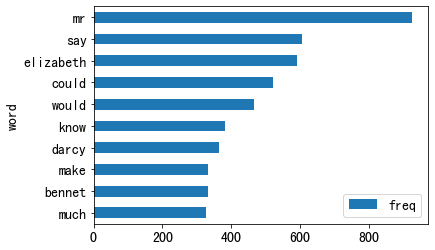

In [82]:
freq_df.iloc[:10].plot.barh(x='word', y='freq').invert_yaxis()
plt.show()

#### 折線圖
依照各章節句數、與字數來計算

In [84]:
chapter_count = pd.DataFrame({
    'chapter': content_df.groupby('chapter').size().index,
    'sentences': content_df.groupby('chapter').size().values,
    'word': token_df.groupby('chapter').size().values,
})
chapter_count[:10]

,chapter,sentences,word
0,0,1,2
1,1,61,855
2,2,53,802
3,3,86,1706
4,4,53,1060
5,5,48,928
6,6,106,2334
7,7,97,1984
8,8,111,1937
9,9,106,1731


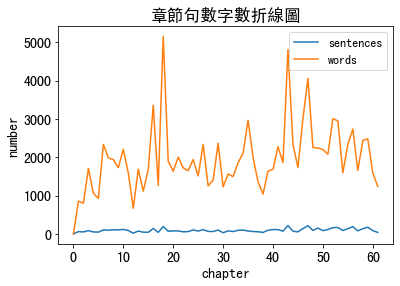

In [85]:
plt.plot(chapter_count['chapter'].values, chapter_count['sentences'].values ,label = 'sentences')
plt.plot(chapter_count['chapter'].values, chapter_count['word'].values, label = 'words')
plt.title('章節句數字數折線圖') # 標題
plt.xlabel('chapter') # x軸標題
plt.ylabel('number') # y軸標題
plt.legend(fontsize=12) # 顯示label
plt.show()

#### 文字雲
利用詞頻製作文字雲，並顯示出詞頻最高的單字

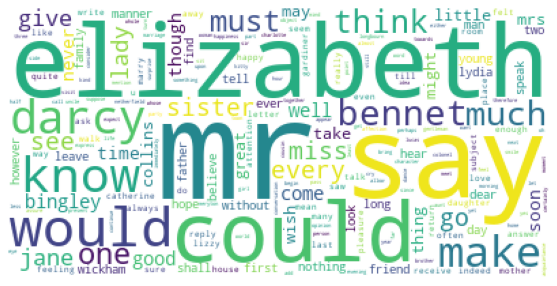

In [90]:
text = freq_df.set_index('word').to_dict()
wordcloud = WordCloud(background_color = 'white').generate_from_frequencies(text['freq'])
plt.figure(figsize=(10,5))
plt.axis('off')
plt.imshow(wordcloud)

### 3.10 更新停用字字典
手動將停用字加入NLTK的停用字字典中 

透過以上的字頻表與文字雲，我們可以發現could、would、much、must這些詞出現很多次，但這些字對於文本分析並不那麼重要，因次我們將這些字加入停用字字典中將他們清除

In [91]:
# 手動加入停用字
newStops = ['could', 'would', 'much', 'must']
stops.extend(newStops)

重新篩選出不是停用字的字

In [92]:
noStop_df = noStop_df[~noStop_df['word'].isin(stops)]
noStop_df

,sentence,chapter,token,word,stem_token,pos,lemma_token
0,TPRIDE PREJUDICE,0,TPRIDE,tpride,tpride,IN,tpride
1,TPRIDE PREJUDICE,0,PREJUDICE,prejudice,prejudic,NN,prejudice
5,It is a truth universally acknowledged that a ...,1,truth,truth,truth,NN,truth
6,It is a truth universally acknowledged that a ...,1,universally,universally,univers,RB,universally
7,It is a truth universally acknowledged that a ...,1,acknowledged,acknowledged,acknowledg,VBD,acknowledge
...,...,...,...,...,...,...,...
121595,Darcy as well as Elizabeth really loved them a...,61,persons,persons,person,NNS,person
121598,Darcy as well as Elizabeth really loved them a...,61,bringing,bringing,bring,VBG,bring
121601,Darcy as well as Elizabeth really loved them a...,61,Derbyshire,derbyshire,derbyshir,NN,derbyshire
121605,Darcy as well as Elizabeth really loved them a...,61,means,means,mean,NNS,mean


重新計算詞頻

In [93]:
freq_df2 = pd.DataFrame(noStop_df['lemma_token'].value_counts())
freq_df2 = freq_df2.reset_index()
freq_df2.columns = ['word', 'freq']
freq_df2

,word,freq
0,mr,926
1,say,605
2,elizabeth,592
3,know,382
4,darcy,365
...,...,...
5342,transient,1
5343,statement,1
5344,outdone,1
5345,jilt,1


In [94]:
# 第一次的詞頻表
freq_df

,word,freq
0,mr,926
1,say,605
2,elizabeth,592
3,could,521
4,would,467
...,...,...
5346,transient,1
5347,statement,1
5348,outdone,1
5349,jilt,1


和第一次的詞頻表做比較，可以看到could, would, much, must等新增的停用字被清除了

重新繪製詞頻表

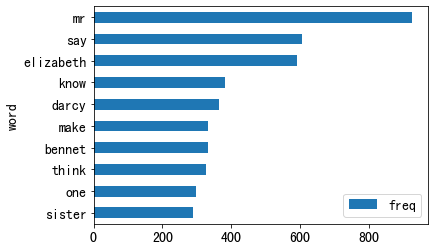

In [95]:
freq_df2.iloc[:10].plot.barh(x='word', y='freq').invert_yaxis()
plt.show()

### 3.11 斷詞字典
英文的文集段詞方式會以空白來斷詞，但有許多專有名詞、地名、人名、名詞片語等(ex.Natural Language Processing、United States、Lydia Bennet)屬於多個字組合才是完整的字詞，這類的字不應該在斷詞時被斷開，因此通常會使用底線來將這些應該合併的字連在一起，使這些字在做斷詞時不會被斷開。

在以上的詞頻表中，可以發現前10多的字有許多人名如Elizabeth、Bennet、BingLey、Jane，而Bennet所指的有可能是Mr. Bennet或是Mrs. Bennet，但在斷詞時會將兩個字分開來，因此我們可以透過將原文中的Mr  Bennet和Mrs  Bennet用Mr_Bennet和Mrs_Bennet取代

In [96]:
content_df["sentence"] = content_df["sentence"].apply(lambda r: r.replace('Mr ','Mr_').replace('Mrs ','Mrs_') )
content_df

,sentence,chapter
0,TPRIDE PREJUDICE,0
0,It is a truth universally acknowledged that a ...,1
0,However little known the feelings or views of ...,1
0,My dear Mr_Bennet said his lady to him one day...,1
0,Mr_Bennet replied that he had not,1
...,...,...
0,By Elizabeths instructions she began to compre...,61
0,Lady Catherine was extremely indignant on the ...,61
0,But at length by Elizabeths persuasion he was ...,61
0,With the Gardiners they were always on the mos...,61


取代完後需要重新進行斷詞、Lemma

In [97]:
# 斷詞
new_df = content_df.assign(token = content_df['sentence'].apply(nltk.word_tokenize)).explode('token')

# 換小寫
new_df = new_df.assign(word = new_df['token'].str.lower())
new_df['word'] = new_df['word'].astype(str)

# 生成pos的dataframe
new_pos_df = pd.DataFrame(nltk.pos_tag(new_df['word']), columns=['word', 'pos']).drop('word', axis=1)

# 合併df
new_df = new_df.merge(new_pos_df, left_index=True, right_index=True)

# 轉換對應的pos
new_df = new_df.assign(pos_lmt = new_pos_df.apply(lambda r: get_wordnet_pos(r['pos']), axis=1))

# 生成lemma_token欄位
new_lemma_df = new_df.assign(lemma_token = new_df.apply(lambda r: get_lemma_token(r['word'],r['pos_lmt']), axis=1)).drop(['pos_lmt','pos'],axis=1)

# 移除停用字
new_noStop_df = new_lemma_df[~new_lemma_df['word'].isin(stops)]

new_noStop_df

,sentence,chapter,token,word,lemma_token
0,TPRIDE PREJUDICE,0,TPRIDE,tpride,tpride
0,TPRIDE PREJUDICE,0,PREJUDICE,prejudice,prejudice
0,It is a truth universally acknowledged that a ...,1,truth,truth,truth
0,It is a truth universally acknowledged that a ...,1,universally,universally,universally
0,It is a truth universally acknowledged that a ...,1,acknowledged,acknowledged,acknowledged
...,...,...,...,...,...
0,Darcy as well as Elizabeth really loved them a...,61,persons,persons,person
0,Darcy as well as Elizabeth really loved them a...,61,bringing,bringing,bringing
0,Darcy as well as Elizabeth really loved them a...,61,Derbyshire,derbyshire,derbyshire
0,Darcy as well as Elizabeth really loved them a...,61,means,means,mean


儲存clean data，以便後續其他使用

In [98]:
new_noStop_df.to_csv("raw_data/clean_en_data.csv", encoding = 'utf-8',index = False)

重新計算詞頻

In [102]:
new_freq_df = pd.DataFrame(new_noStop_df['lemma_token'].value_counts())
new_freq_df = new_freq_df.reset_index()
new_freq_df.columns = ['word', 'freq']
new_freq_df

,word,freq
0,elizabeth,618
1,said,398
2,one,298
3,sister,288
4,every,282
...,...,...
6313,ii,1
6314,joyfully,1
6315,predict,1
6316,designing,1


重新畫出文字雲，可以看到文字雲中出現mrs_bennet，並沒有mr_bennet，代表在文本中Mrs. bennet的出現次數比Mr. bennet多

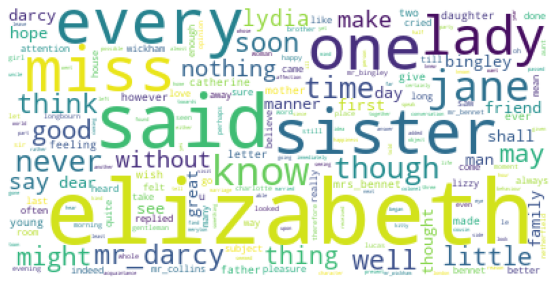

In [103]:
text2 = new_freq_df.set_index('word').to_dict()
wordcloud_2 = WordCloud(background_color = 'white').generate_from_frequencies(text2['freq'])
plt.figure(figsize=(10,5))
plt.axis('off')
plt.imshow(wordcloud_2)

資料清理的過程往往是花費做多時間的工程，因為在做完第一次的斷詞、正規化、清除停用字後，我們會發現還是會有許多不重要的字沒有被清理到，或是有些兩個字以上的專有名詞、名詞片語被斷開，因此在進行資料分析前，必須不斷經歷以上過程，更新停用字、字典，以便在後續的分析中能得到重要且正確的分析結果